<a href="https://colab.research.google.com/github/ffrnz/GymTracker/blob/test1/lstmqqq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.4.1


In [11]:
# More imports
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
from scipy import stats

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

ModuleNotFoundError: ignored

In [13]:
!pip install arch
from arch import arch_model

In [30]:
import yfinance as yf
df = yf.download("QQQ", start="2014-01-01", end="2021-02-28")

[*********************100%***********************]  1 of 1 completed


In [31]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,87.550003,87.580002,87.019997,87.269997,81.452171,29177500
2014-01-03,87.269997,87.349998,86.620003,86.639999,80.864151,35723700
2014-01-06,86.660004,86.760002,86.000000,86.320000,80.565483,32073100
2014-01-07,86.720001,87.250000,86.559998,87.120003,81.312172,25860600
2014-01-08,87.139999,87.550003,86.949997,87.309998,81.489517,27197400


In [32]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-22,326.500000,327.799988,322.230011,322.440002,322.033264,47256900
2021-02-23,317.000000,323.200012,311.000000,321.480011,321.074493,97241900
2021-02-24,318.739990,324.450012,315.959991,324.130005,323.721130,58206300
2021-02-25,321.390015,324.029999,311.239990,312.829987,312.435364,110182600
2021-02-26,315.850006,319.109985,310.880005,314.140015,313.743744,104682900


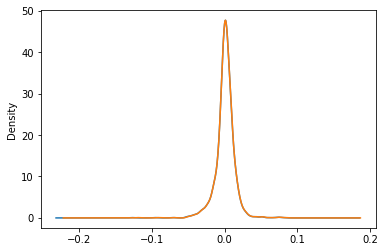

In [33]:
df['PrevClose'] = df['Close'].shift(1) # move everything up 1
df['Return'] = (df['Close'] - df['PrevClose']) / df['PrevClose']
df['LogReturn'] = (np.log( df['Close'] / df['PrevClose']))
df['LogReturn'].plot.kde()
df['Return'].plot.kde()
log_returns = df['LogReturn'].dropna()

In [34]:
mean = log_returns.mean()
std = log_returns.std()
var = log_returns.var()
minimum = log_returns.min()
maximum = log_returns.max()
skew = stats.skew(log_returns)
excess_kurtosis = stats.kurtosis(log_returns)

summary_statistics = pd.DataFrame({'mean': mean,
                                   'stdev': std,
                                   'variance': var,
                                   'min': minimum,
                                   'max': maximum,
                                   'skew': skew,
                                   'excess_kurt': excess_kurtosis
                                  } , index=["TQQQ"] )

print(stats.jarque_bera(log_returns))
summary_statistics

(9660.007574499854, 0.0)


,mean,stdev,variance,min,max,skew,excess_kurt
TQQQ,0.000712,0.012976,0.000168,-0.127592,0.081309,-0.791744,11.238001



From the histogram and the summary statistics, it is evident that TQQQ is leptokurtic. The Jarque Bera test further comfirms this, implying that log returns does not follow a normal distribution.
#Volatility Clustering
Financial Time series often exhibit volatility clustering which refers to the observation that volatility changes over time and its degree shows a tendency to persist, creating periods of high volatility interspersed with periods of relative clam. This is also known as autoregressive conditional heteroskedasticity.

As seen in the autocorrelation function and partial autocorrelation function graphs below, log returns seems to randomly fluctuate around 0, implying that there is little autocorrelation.

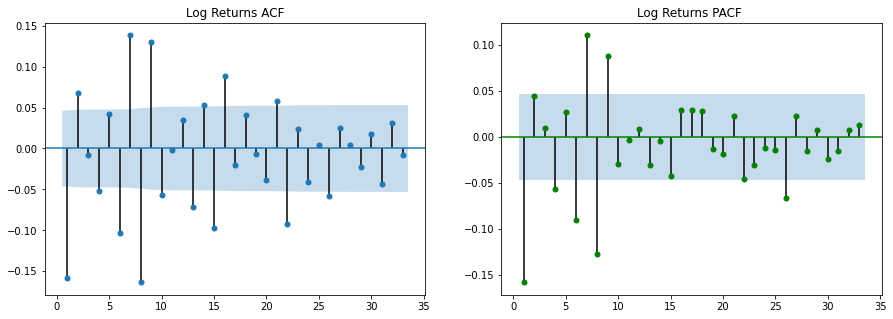

In [35]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
_  = plot_acf(log_returns, ax = ax1, title='Log Returns ACF', zero=False)
_  = plot_pacf(log_returns, ax = ax2, title='Log Returns PACF ', color='green', zero=False)

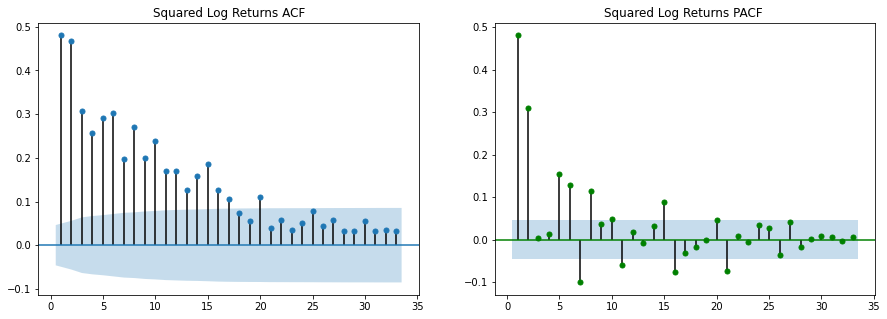

In [36]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
_  = plot_acf(log_returns**2, ax = ax1, title='Squared Log Returns ACF', zero=False)
_  = plot_pacf(log_returns**2, ax = ax2, title='Squared Log Returns PACF ', color='green', zero=False)

In [37]:
model = arch_model(log_returns, p=3, q=0)

In [38]:
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: -5525.386849155744
Iteration:      2,   Func. Count:     21,   Neg. LLF: -5525.511590911697
Iteration:      3,   Func. Count:     33,   Neg. LLF: -5525.730767235942
Iteration:      4,   Func. Count:     47,   Neg. LLF: -5525.730930303163
Iteration:      5,   Func. Count:     60,   Neg. LLF: -5525.7311721252245
Iteration:      6,   Func. Count:     74,   Neg. LLF: -5525.7316007354875
Iteration:      7,   Func. Count:     88,   Neg. LLF: -5525.731965985562
Iteration:      8,   Func. Count:    101,   Neg. LLF: -5525.73328371189
Iteration:      9,   Func. Count:    115,   Neg. LLF: -5525.7345119037545
Iteration:     10,   Func. Count:    127,   Neg. LLF: -5525.766531599867
Iteration:     11,   Func. Count:    140,   Neg. LLF: -5525.786094486153
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5525.786087154194
            Iterations: 15
            Function evaluations: 140
            Gradient

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001683. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:              LogReturn   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                5525.79
Distribution:                  Normal   AIC:                          -11041.6
Method:            Maximum Likelihood   BIC:                          -11014.1
                                        No. Observations:                 1800
Date:                Sat, Mar 27 2021   Df Residuals:                     1799
Time:                        21:31:30   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         9.0268e-04  2.503e-04      3.606  3.112e-04 [4.120e-04,1.393e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      8.4214e-05  6.099e-06     13.807  2.304e-43 [7.226e-05,9.617e-05]
alpha[1]       0.0667  1.729e-02      3.855  1.157e-04   [3.277e-02,  0.101]
alpha[2]       0.0667  1.773e-02      3.764  1.671e-04   [3.198e-02,  0.101]
alpha[3]       0.0667  1.997e-02      3.339  8.410e-04   [2.753e-02,  0.106]
============================================================================

Covariance estimator: robust
"""

In [39]:
rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = log_returns[:-(test_size-i)]
    model = arch_model(train, p=3, q=0)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

Streaming output truncated to the last 5000 lines.
to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001104. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning

In [40]:
rolling_predictions = pd.Series(rolling_predictions, index=log_returns.index[-365:])

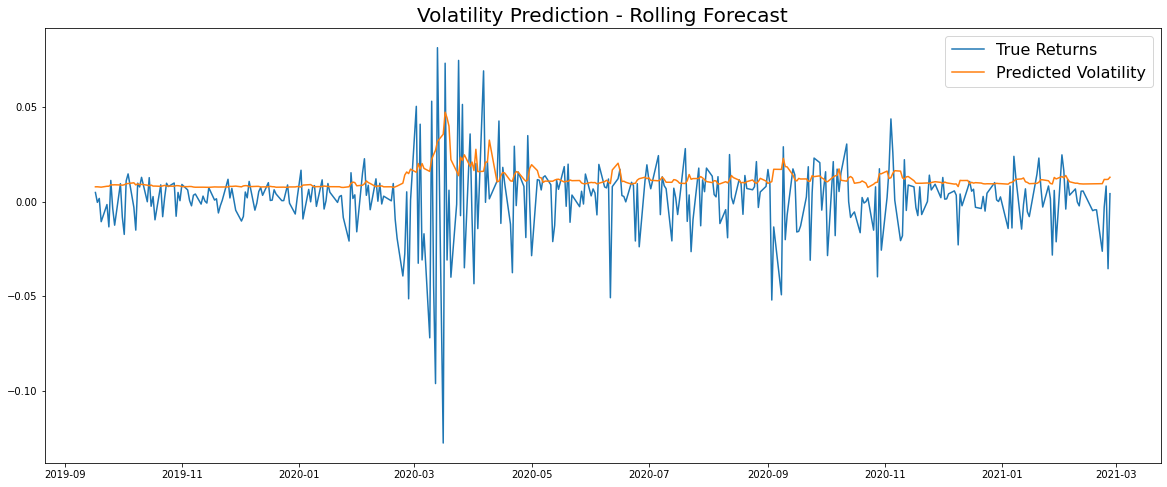

In [42]:
plt.figure(figsize=(20,8))
true, = plt.plot(log_returns[-365:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

In [49]:
rolling_predictions.max()

0.04722165876398081